In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
use_sparse = True


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

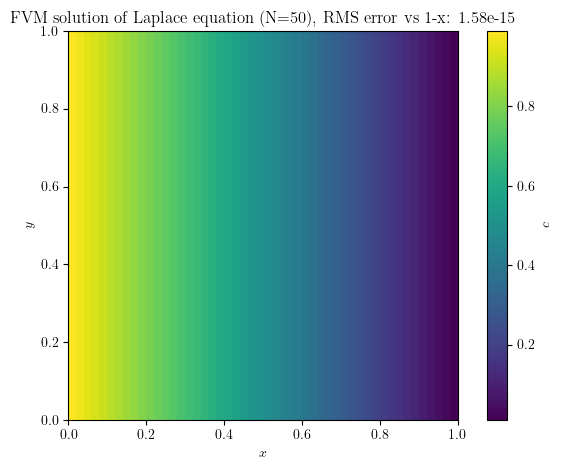

In [ ]:
def idx(i, j, N):
    # i = 0..N-1 (x-index), j = 0..N-1 (y-index)
    return i + N * j

def build_system(N):
    Delta = 1.0 / N
    n = N * N

    if use_sparse:
        A = lil_matrix((n, n), dtype=float)
    else:
        A = np.zeros((n, n), dtype=float)

    b = np.zeros(n, dtype=float)

    for j in range(N):
        for i in range(N):
            r = idx(i, j, N)

            on_left = (i == 0)
            on_right = (i == N - 1)
            on_bottom = (j == 0)
            on_top = (j == N - 1)

            # mixed BCs:
            # Dirichlet: c=1 at x=0, c=0 at x=1
            # Neumann: dc/dy=0 at y=0 and y=1

            if (not on_left) and (not on_right) and (not on_bottom) and (not on_top):
                # interior: -4 c + neighbors = 0
                A[r, r] = -4.0
                A[r, idx(i-1, j, N)] = 1.0
                A[r, idx(i+1, j, N)] = 1.0
                A[r, idx(i, j-1, N)] = 1.0
                A[r, idx(i, j+1, N)] = 1.0

            elif on_left and (not on_bottom) and (not on_top):
                # left boundary (Dirichlet c=1 at face): -5 c + (right, up, down) = -2
                A[r, r] = -5.0
                A[r, idx(i+1, j, N)] = 1.0
                A[r, idx(i, j-1, N)] = 1.0
                A[r, idx(i, j+1, N)] = 1.0
                b[r] = -2.0

            elif on_right and (not on_bottom) and (not on_top):
                # right boundary (Dirichlet c=0 at face): -5 c + (left, up, down) = 0
                A[r, r] = -5.0
                A[r, idx(i-1, j, N)] = 1.0
                A[r, idx(i, j-1, N)] = 1.0
                A[r, idx(i, j+1, N)] = 1.0

            elif on_bottom and (not on_left) and (not on_right):
                # bottom boundary (Neumann): -3 c + (left, right, up) = 0
                A[r, r] = -3.0
                A[r, idx(i-1, j, N)] = 1.0
                A[r, idx(i+1, j, N)] = 1.0
                A[r, idx(i, j+1, N)] = 1.0

            elif on_top and (not on_left) and (not on_right):
                # top boundary (Neumann): -3 c + (left, right, down) = 0
                A[r, r] = -3.0
                A[r, idx(i-1, j, N)] = 1.0
                A[r, idx(i+1, j, N)] = 1.0
                A[r, idx(i, j-1, N)] = 1.0

            else:
                # corners: apply both rules simultaneously (Dirichlet in x, Neumann in y)
                if on_left and on_bottom:
                    # -4 c + (right, up) = -2
                    A[r, r] = -4.0
                    A[r, idx(i+1, j, N)] = 1.0
                    A[r, idx(i, j+1, N)] = 1.0
                    b[r] = -2.0
                elif on_left and on_top:
                    # -4 c + (right, down) = -2
                    A[r, r] = -4.0
                    A[r, idx(i+1, j, N)] = 1.0
                    A[r, idx(i, j-1, N)] = 1.0
                    b[r] = -2.0
                elif on_right and on_bottom:
                    # -4 c + (left, up) = 0
                    A[r, r] = -4.0
                    A[r, idx(i-1, j, N)] = 1.0
                    A[r, idx(i, j+1, N)] = 1.0
                elif on_right and on_top:
                    # -4 c + (left, down) = 0
                    A[r, r] = -4.0
                    A[r, idx(i-1, j, N)] = 1.0
                    A[r, idx(i, j-1, N)] = 1.0

    return A, b

N=50
A, b = build_system(N)

if use_sparse:
    c_vec = spsolve(A.tocsr(), b)
else:
    c_vec = np.linalg.solve(A, b)

C = c_vec.reshape((N, N), order="F")

Delta = 1.0 / N
x = (np.arange(N) + 0.5) * Delta
y = (np.arange(N) + 0.5) * Delta
X, Y = np.meshgrid(x, y, indexing="ij")
C_exact = 1.0 - X
err = np.sqrt(np.mean((C - C_exact) ** 2))

plt.figure()
plt.imshow(C.T, origin="lower", extent=[0, 1, 0, 1], cmap="viridis", aspect="equal")
plt.colorbar(label="$c$")
plt.xlabel("$x$")
plt.ylabel("$y$")
# plt.title(f"FVM solution of Laplace equation (N={N}), RMS error vs 1-x: {err:.2e}")
plt.tight_layout()
plt.savefig("../../../figs/pde/fvm_pde_numerical.pdf", bbox_inches="tight", transparent=True)
plt.show()
